# Reference-based data integration

### Introduction

This notebook demonstrates how to project your scRNA-seq data onto our reference atlas.

As test data for this tutorial, we analyze a sample from our PMCA Jak2 dataset. The test data is stored in the "data" directory. Due to the file size limit of the git repository, the data of our reference atlas ('Dahlin_atlas.h5ad') is provided at our [PMCA web portal](https://gottgens-lab.stemcells.cam.ac.uk/preleukemia_atlas/).

### Importing packages

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import umap
import pickle
from matplotlib import rcParams
rcParams['figure.figsize'] = (5, 5)
import warnings
warnings.filterwarnings("ignore")

### Dahlin's reference atlas

Once you have downloaded our reference atlas, you can load and explore the atlas. After data integration, your data will be visualized in the same UMAP space.

In [2]:
dahlin = sc.read('data/Dahlin_atlas.h5ad')

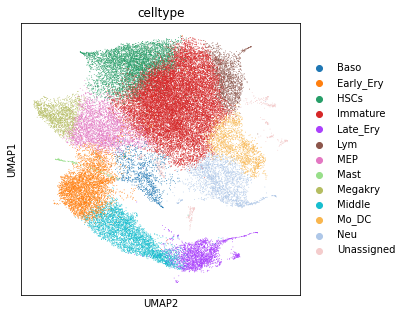

In [3]:
sc.pl.umap(dahlin,color='celltype',components=['2,1'])

### Preprocessing query data

This tutorial uses a previously preprocessed dataset stored in the "data" directory.<br>
When you project your own data, please make sure that the data matrix (AnnData.X) contains unscaled log-normalized expression. Regarding the preprocessing of your data, please refer to the literature for best practices.

The structure of our test data is shown below.

In [4]:
adata = sc.read('data/PMCA_Jak2_SLX11516_SIGAC2.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 7131 × 20465
    obs: 'library', 'dataset', 'Condition', 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

### Data integration and label transfer

Data integration and label transfer steps are coded in an R script located in the "scripts" directory. When you project your own data, please change the "params" section within the R script.

In [6]:
!R --vanilla --slave < scripts/integration.R

Attaching SeuratObject
Warning messages:
1: replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’ 
2: replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘pillar’ 
Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5          ✔ purrr   0.3.4     
✔ tibble  3.0.6          ✔ dplyr   1.0.4.9000
✔ tidyr   1.1.2          ✔ stringr 1.4.0     
✔ readr   1.4.0          ✔ forcats 0.5.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Creating h5Seurat file for version 3.1.5.9900
Adding X as scale.data
Adding raw/X as data
Adding raw/X as counts
Adding meta.features from raw/var
Merging feature_types from scaled feature-level metadata
Merging gene_ids f

<br>This example script generates two output files:<br>
- Projected log-expression: data/PMCA_Jak2_SLX11516_SIGAC2_Integrated.h5ad<br>
- Transferred cell type annotation: data/PMCA_Jak2_SLX11516_SIGAC2_label_transfer.csv

### Embedding query data onto reference UMAP space

Now that the query cells have been projected onto the log-expression space of the reference atlas, we can plot them in the Dahlin's UMAP space by using the same scaling factors and the PCA/UMAP models.

In [7]:
# Extracting the gene-wise means & SDs of the Dahlin's reference atlas
ref_mean = dahlin.var['mean'][dahlin.var.highly_variable].values
ref_std = dahlin.var['std'][dahlin.var.highly_variable].values
hvg = np.genfromtxt('scripts/Dahlin_HVG.txt', dtype=str)

In [8]:
# Extracting the PC projection matrix of the Dahlin's atlas
pca_basis = dahlin.varm['PCs'][dahlin.var.highly_variable,:]

In [9]:
# Loading the saved UMAP model
f_name = 'scripts/umap_ref.sav'
umap_ref = pickle.load((open(f_name, 'rb')))

In [10]:
# Loading the integrated query dataset
integrated = sc.read('data/PMCA_Jak2_SLX11516_SIGAC2_Integrated.h5ad')

In [11]:
# Filtering genes
integrated = integrated[:,hvg].copy()

In [12]:
# Scaling the query sample to the Dahlin's data range
query_X = integrated.X.toarray().copy()
query_X -= ref_mean
query_X /= ref_std

In [13]:
# Compute the dot product with the Dahlin's PCA basis
integrated.obsm['X_pca'] = np.dot(query_X, pca_basis).astype('float32')

In [14]:
# Compute the UMAP coordinates from the PC coordinates using the saved UMAP model
X2 = integrated.obsm['X_pca']
X2_contiguous = np.ascontiguousarray(X2, dtype=np.float32)
X2_umap = umap_ref.transform(X2_contiguous)
integrated.obsm['X_umap'] = X2_umap

In [15]:
# Read in the transferred cell type label
label_transfer = pd.read_csv('data/PMCA_Jak2_SLX11516_SIGAC2_label_transfer.csv', header=0,index_col=0)

In [16]:
# Add the cell type label to the obs metadata
integrated.obs = integrated.obs.merge(label_transfer, left_index = True, right_index = True)

In [17]:
integrated.uns['predicted.id_colors']=dahlin.uns['celltype_colors']

... storing 'library' as categorical
... storing 'dataset' as categorical
... storing 'Condition' as categorical
... storing 'celltype' as categorical
... storing 'predicted.id' as categorical


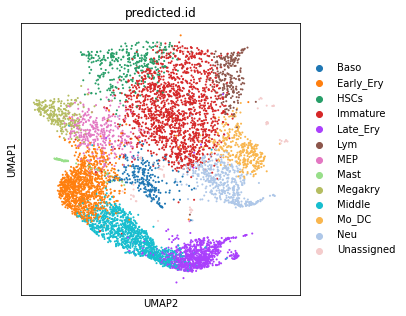

In [18]:
sc.pl.umap(integrated,color=['predicted.id'],components=['2,1'])